# Principle Component Analysis
---

In [400]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler

In basic 2D to 1D dimensional reduction terms, the aim of Principle Component Anaylysis (PCA) is to find a vector $ u^{(1)} \in \mathbb{R}^{n} $ onto which we can project our data so as to minimise the projection error. In the more general sense, and with larger dimensions of data, as is likely in reality, we want to reduce from n-dimensions to k-dimensions, where k < n.

In general we want to find the vectors $ u^{(1)}, u^{(2)}, u^{(3)} ... u^{(k)} $ onto which we can project our data, so as to minimise the projection error. We do this through finding the directions of maximum variance in high-dimensional data and projecting it onto a new subspace with equal or lower dimensions than that started with.

Covariance is a measure of how much two random variables vary together. It's similar to variance, but where variance tells you how a single variable varies, co variance tells you how two variables vary together.

A covariance matrix is a matrix whose element in the i, j position is the covariance between the i-th and j-th elements of a given vector.

### Summary of the Principle Component Analysis process

- Standardise the input data, X, with appropriate feature scaling and zero mean
- Produce the covariance matrix of our standardised input data
- Through decomposing the covariance matrix, determine our eigenvalues and eigenvectors
- Sort the eigenvalues and associated eigenvectors in descending order 
- Choose the k largest eigenvectors, where k is the number of new features after dimensionality reduction, and produce the projection matrix
- Transform our data X to obtain the new k-dimensional dataset using the projection matrix.
---

In [401]:
datafile = loadmat('machine-learning-ex7/ex7/ex7data1.mat', struct_as_record=False)
X = datafile['X']
print("The shape of X is: {}".format(X.shape))

The shape of X is: (50, 2)


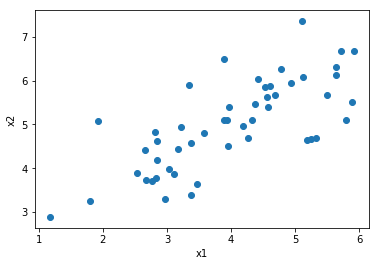

In [402]:
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

### Reduce 2D to 1D

We want to carry out:

$ x^{(i)} \in \mathbb{R}^{2} \longrightarrow  z^{(i)} \in \mathbb{R} $


First we compute the co-variance matrix, given by: 

$ \Sigma = \frac{1}{m} \sum_{i=1}^{n} \big(x^{i})(x^{i})^{T} $

Where m is the number of training samples, and X is our data matrix with each row representing one data sample. For this to work, we must ensure that X has been normalised with a zero mean.

(note: the greek sigma (left of bracket) looks exactly like the symbol for sum, which can be confusing...)

We then need to compute the eigenvectors of $ \Sigma $, which correspond to the principle components of variation in our data.

We choose the first k columns of our sorted (in descending order by corresponding eigenvalue) eigenvectors matrix for the new k-dimensional (where k should be less than original n-dimensional input data). Using this matrix, we can then project our n-dimensional data into our k-dimensions, with the chosen principle components of largest variance. 

---

### Data preprocessing and calculation of covariance matrix, eigenvectors and eigenvalues

Before applying any Principle Component Analysis we should preprocess our data so that are features are scaled or normalised appropriately. 

In [403]:
def zero_mean(X):
    """Apply mean normalisation to our data"""
    normalised = X - np.mean(X, axis=0)
    return normalised

In [404]:
def covariance(X):
    """Returns covariance matrix of X. Note: X must be mean normalised."""
    c_matrix = np.dot(X.T, X) / X.shape[0]
    return c_matrix

def eigenvectors(X):
    return np.linalg.eig(X)

In [405]:
# scale and normalise our data prior to PCA
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
#X_norm = zero_mean(X_std)
X_norm = X_std

# find covariance matrix and eigenvalues, eigenvectors
X_covariance = covariance(X_norm)

# the columns eigvecs[:, i] correspond to the eigenvector for eigenvalue[i]
eigvalues, eigvecs = eigenvectors(X_covariance)

print(eigvalues)
print(eigvecs)

[1.73553038 0.26446962]
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


Remember that an eigenvector, v, satisfies the following condition (from linear algebra):

$ \Sigma v = \lambda v $

Where $ \lambda $ is a scalar, which is known as an eigenvalue.

---
### Plotting the Eigenvectors on our original data

By centering them on our data mean, we'll draw the approximate eigenvectors against our original data. 

For this plot, using  our eigenvectors we'll center our vectors on the X data mean, and make the length of each eigenvector equal to the mean projection matrix standard deviation (random choice for a suitable arrow length). Ideally, we'd represent the vectors with their accurate magnitudes, to illustrate the amount of data variance that specific vector (principle component) represents, however I have not in this case.

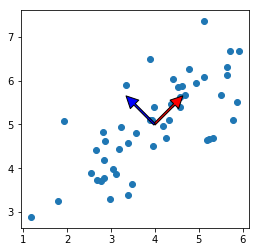

In [406]:
# co-ordinates of mean on our 2D plot
mean = np.mean(X, axis=0)

# projection matrix using normalised X and eigenvectors
projected_data = np.dot(X_norm, eigvecs)
# mean standard dev of projection matrix for vector length - used as a reasonable arrow length for our plot
sigma = projected_data.std(axis=0).mean()

# plot original data scatter
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1])

# colours for eigvec plots
colours = ['red', 'blue']

# plot an arrow in the direction of each eigenvector
for i, axis in enumerate(eigvecs.T):
    start, end = mean, mean + sigma*axis
    ax.annotate('', xy=end, xycoords='data',
               xytext=start, textcoords='data',
               arrowprops=dict(facecolor=colours[i], width=2.0))
ax.set_aspect('equal')
plt.show()

This plot successfully shows our eigenvectors visualised against the original data. The red arrow represents primary  eigenvector with the most variance. We know this is the case, since it has the largest corresponding eigenvalue.

---

### Principle components and their associated variance

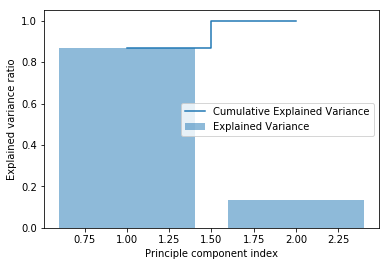

In [407]:
eigval_total = sum(eigvalues)
variance_ratio = [(i/eigval_total) for i in sorted(eigvalues, reverse=True)]
cum_var_ratio = np.cumsum(variance_ratio)

plt.bar(range(1, eigvalues.shape[0] + 1), variance_ratio, alpha=0.5, align='center', label='Explained Variance')
plt.step(range(1, eigvalues.shape[0] + 1), cum_var_ratio, where='mid', label='Cumulative Explained Variance')
plt.xlabel("Principle component index")
plt.ylabel("Explained variance ratio")
plt.legend(loc='best')
plt.show()

Clearly, we have one principle component that accounts for almost all (85%+) the variance in our data.

---

### Choosing the number of principle components, k

Since we want to reduce our dataset dimensionality, we only want a subset of the eigenvectors, which are known as the principle components. We choose those that contain most of the information (variance).

A common convention in choosing k is to use two terms: Average square projection error and the total variation:

Average Square Projection Error $ = \frac{1}{m} \sum_{i=1}^{m} \mid\mid x^{i} - x_{approx}^{i} \mid\mid^{2} $

Total Variation in the Data $ = \frac{1}{m} \sum_{i=1}^{m} \mid\mid x^{i} \mid\mid^{2} $

Typically we choose k so that 99% of variance is retained, which can be determined using the ratio of these terms:

$$ \frac{\frac{1}{m} \sum_{i=1}^{m} \mid\mid x^{i} - x_{approx}^{i} \mid\mid^{2}}{\frac{1}{m} \sum_{i=1}^{m} \mid\mid x^{i} \mid\mid^{2}}  \leq 0.01 $$

In [408]:
# choose only first k columns of U - k is 1 in this case
U_reduce = eigvecs[:, :1]
U_reduce

array([[0.70710678],
       [0.70710678]])

So we have a vector of size (2,1) representing the principle component that we have chosen to use for projecting our data from 2D to 1D.

In [409]:
print(U_reduce.shape)
print(X_norm.shape)

reduced_X_norm = X_norm.dot(U_reduce)
print("X data after PCA is now of shape: {}".format(reduced_X_norm.shape))

(2, 1)
(50, 2)
X data after PCA is now of shape: (50, 1)


In [410]:
# undo the processes of mean normalisation and scaling of features
temp = np.column_stack((reduced_X_norm, np.zeros(reduced_X_norm.shape[0]).T))
reduced_X = scaler.inverse_transform(temp)[:, 0]
print(reduced_X)

[2.25165705 5.06015697 2.56742725 2.08031413 2.51072491 5.12360717
 2.51584459 6.70833597 4.02409311 4.89704313 4.72280744 4.63121148
 4.09340895 4.5999187  2.17287491 6.21436015 5.01906772 2.87901492
 6.6949513  4.54427637 6.56432714 3.53752773 6.06190968 3.92916442
 2.0556232  3.39918751 5.42587206 5.35024683 3.01123239 3.99731483
 4.25396519 5.74636244 2.43463889 4.67734027 3.20068132 5.56042707
 2.02964461 5.60615668 1.0165252  4.31268439 5.12355742 2.95783393
 2.4835042  5.13852701 1.88422166 4.30508574 0.28138802 2.58066656
 3.56200432 5.66454718]


#### Finally, we can visualise our new 1D data, like so:

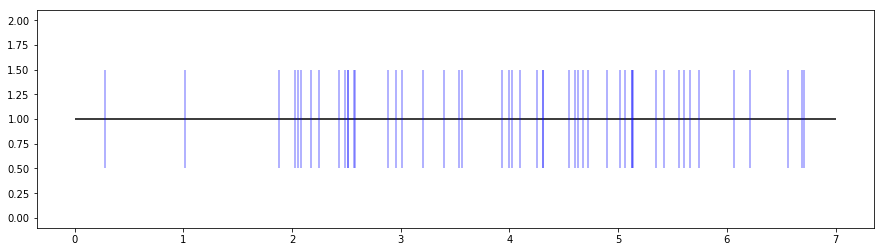

In [411]:
plt.figure(figsize=(15,4))
plt.hlines(1, np.floor(reduced_X.min()), np.ceil(reduced_X.max()))  # Draw a horizontal line
plt.eventplot(reduced_X.flatten(), orientation='horizontal', colors='b', alpha=0.4)
plt.show()

#### Reconstruction from compressed data

We need to remember that our data is scaled and mean-normalised, which must be undone before plotting against the orignal data.

In [412]:
approx_X_norm = U_reduce*reduced_X_norm.T
approx_X_norm = approx_X_norm.T
approx_X_norm.shape

(50, 2)

In [413]:
# recover approximate X by undoing the scaling and mean normalisation
approx_X = scaler.inverse_transform(approx_X_norm)

#### Finally, we can plot our reconstructed data and visualise it against our original data

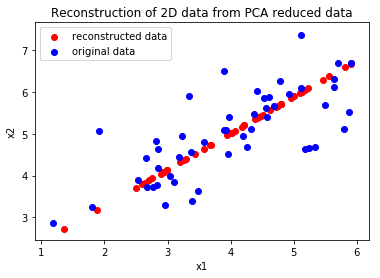

In [414]:
plt.scatter(approx_X[:, 0], approx_X[:, 1], color='r', label='reconstructed data')
plt.scatter(X[:, 0], X[:, 1], color='b', label='original data')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Reconstruction of 2D data from PCA reduced data")
plt.legend(loc='best')
plt.show()

Clearly we loose accuracy from the true original data, however its not bad as an approximation for a reconstruction.

---
## Face Image Dimensionality Reduction

100 face images of dimension 32 x 32

In [447]:
face_data = loadmat('machine-learning-ex7/ex7/ex7faces.mat', struct_as_record=False)
X = face_data['X']
print("The shape of X is: {}".format(X.shape))

The shape of X is: (5000, 1024)


#### Preview some of our image data

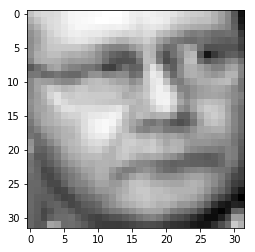

In [448]:
plt.imshow(X[1].reshape((32, 32)).T, cmap='gray')
plt.show()

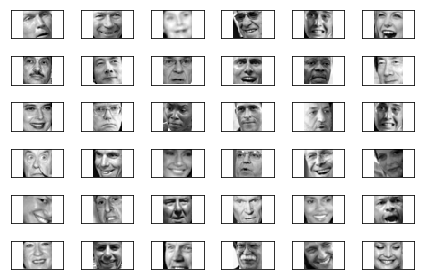

In [449]:
fig, ax = plt.subplots(nrows = 6, ncols = 6, sharex = True, sharey = True)
ax = ax.flatten()
for i in range(36):
    img_num = random.randint(1, X.shape[0])
    ax[i].imshow(X[img_num].reshape((32, 32)).T, cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

#### Preprocess, construct covariance matrix and obtain eigenvalues, eigenvectors

In [450]:
# mean normalise and standardise our image data features
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# find covariance matrix and eigenvalues, eigenvectors
X_covariance = covariance(X_norm)

# the columns eigvecs[:, i] correspond to the eigenvector for eigenvalue[i]
eigvalues, eigvecs = eigenvectors(X_covariance)

print(eigvalues.shape)
print(eigvecs.shape)

print(eigvalues[:5])

(1024,)
(1024, 1024)
[337.02502183 130.93879726  54.69353175  39.72989611  33.16261683]


#### Create pairs of eigenvalues, eigenvectors and sort in descending order

In [451]:
# create pairs of eigenvalues, eigenvectors and sort in descending order
eig_pairs = [(np.abs(eigvalues[i]), eigvecs[:, i]) for i in range(eigvalues.shape[0])]
eig_pairs.sort(key=lambda x: x[0], reverse=True)
print(eig_pairs[:5])

[(337.0250218267053, array([0.01425307, 0.01474233, 0.01501482, ..., 0.00895052, 0.00769526,
       0.00692969])), (130.9387972573509, array([ 0.03606596,  0.03809858,  0.03988747, ..., -0.03119618,
       -0.0290752 , -0.02725819])), (54.693531748056095, array([-0.04561884, -0.04756249, -0.05082085, ..., -0.05691806,
       -0.05579144, -0.05339471])), (39.729896107797806, array([-0.03357392, -0.03342374, -0.03325487, ...,  0.01704122,
        0.01543529,  0.01361261])), (33.162616828858226, array([0.00801162, 0.00709208, 0.00481185, ..., 0.05850005, 0.05550395,
       0.05173015]))]


#### Create a k-dimensional projection matrix using the eigenvalue, eigenvector sorted pairs

In [452]:
k=100

w_matrix = eig_pairs[0][1][:, np.newaxis]

for i in range(1, k):
    w_matrix = np.hstack((w_matrix, eig_pairs[i][1][:, np.newaxis]))

print(w_matrix.shape)

(1024, 100)


We now have our 1024 x 100 projection matrix containing the top 100 principle components (eigenvectors).

We can transform the entire normalised image data X onto our 100 principle components by calculating the matrix dot product:

In [453]:
X_pca_norm = X_norm.dot(w_matrix)
print(X_pca_norm.shape)

(5000, 100)


#### Visualise our images with pca dimensionality reduction

In [454]:
# pad our dim reduced X with 924 empty cols to allow reverse of scaling / normalising
temp = np.column_stack((X_pca_norm, np.zeros((X_pca_norm.shape[0], 924))))
X_pca = scaler.inverse_transform(temp)[:, :k]
print(X_pca.shape)

(5000, 100)


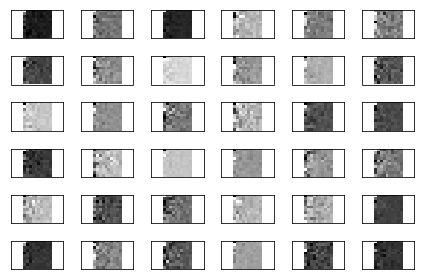

In [460]:
fig, ax = plt.subplots(nrows = 6, ncols = 6, sharex = True, sharey = True)
ax = ax.flatten()
for i in range(36):
    img_num = random.randint(1, X_pca.shape[0])
    ax[i].imshow(X_pca[img_num].reshape((10, 10)).T, cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Our principle components can be visualised above for 32 random images - not much can be made out as shown, however with a higher number of principle components the basic features would be apparent.

#### Reconstruction of face images from pca transformed data

In [456]:
approx_X_norm = np.dot(w_matrix, X_pca_norm.T)
approx_X_norm = approx_X_norm.T
approx_X_norm.shape

# recover approximate X by undoing the scaling and mean normalisation
approx_X = scaler.inverse_transform(approx_X_norm)

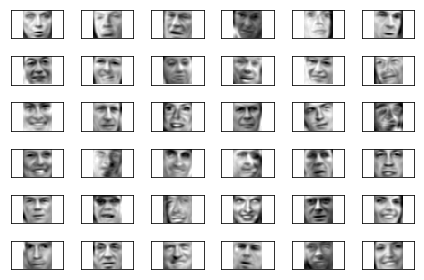

In [458]:
fig, ax = plt.subplots(nrows = 6, ncols = 6, sharex = True, sharey = True)
ax = ax.flatten()
for i in range(36):
    img_num = random.randint(1, approx_X.shape[0])
    ax[i].imshow(approx_X[img_num].reshape((32, 32)).T, cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

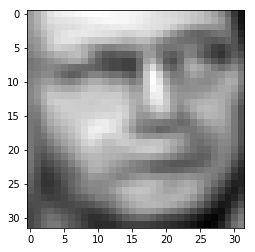

In [465]:
plt.imshow(approx_X[1].reshape((32, 32)).T, cmap='gray')
plt.show()

As can be seen, the images are more blurred than the original, however considering they were reproduced from 100 dimensions back to 1024 dimensions this is not bad! The fine details are lost, whilst the general features and overall shape are preserved from the top principle components.

With ten times less dimensions, our pca reduced data is significantly faster to train, especially for deep learning neural networks. This is what makes pca so valuable, and in most cases the end-product will have similar performance, providing principle component analysis has been carried out correctly with sufficient variance retained by the top k principle components.